# คำนวณการบดบังของลำบีม 
โค้ดจาก https://docs.wradlib.org/en/stable/notebooks/beamblockage/wradlib_beamblock.html
สิ่งที่ต้องเตรียม
* ข้อมูลแบบจำลองความสูงเชิงเลขที่ครอบคลุมพื้นที่การสังเกตุการณ์เรดาร์ ต้องเผื่อพื้นที่ให้ใหญ่กว่าพื้นที่เรดาร์ 
* ค่าพิกัดสถานีเรดาร์ในระบบพิกัดภูมิศาสตร์ ความสูงของสถานีเรดาร์จาก DEM ที่ใช้ เช่น GTOPO30/STRM 
* ค่ามุมยก (el) ค่าความกว้างของลำบีม (beam width) ความละเอียดของbin (range bins) จำนวนรังสีเรดาร์ในแต่ละมุมยก (rays)

@ดัดแปลงโดย ผศ.ดร.นัฐพล มหาวิค สาขาวิชาภูมิศาสตร์ มหาวิทยาลัยนเรศวร  https://www.youtube.com/user/mooaon3637/playlists

## การติดตั้งโปรแกรมwradlibใน anaconda
*  วิธีที่ 1 สามารถติดตั้งโดยใช้คำสั่งใน anaconda prompt

conda create --name wradlib_pbb python=3.7

activate wradlib_pbb
conda config --add channels conda-forge
conda config --set channel_priority strict

conda install wradlib=1.7.0 gdal=3.1.0
conda install jupyter
conda install xarray=0.16.1

* วิธีที่ 2 ติดตั้งโดยใช้ yml ใช้คำสั่ง
conda env create -f wradlib_pbb.yml

ไฟล์ wradlib_pbb.yml เก็บอยู่ในโฟลเดอร์ข้อมูลที่แนบไปด้วย
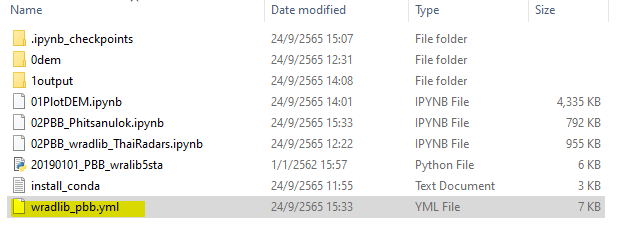

ตั้งค่า conda-forge ให้เป็น high priority เพื่อจะได้ติดตั้ง wradlib ได้โดยไม่เกิดปัญหา
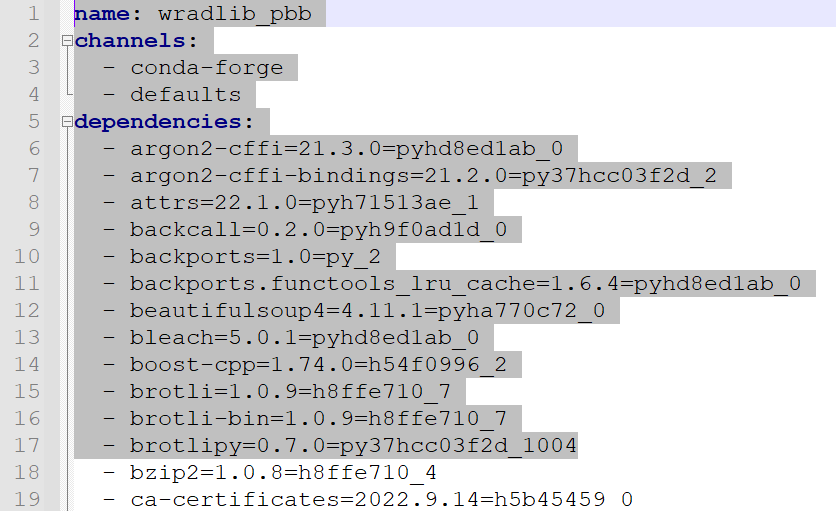


In [1]:
import wradlib as wrl
import matplotlib.pyplot as pl
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')
try:
    get_ipython().magic("matplotlib inline")
except:
    pl.ion()
import numpy as np

C:\Users\Admin\anaconda3\envs\wradlib_pbb\lib\site-packages\wradlib\io\radolan.py:835: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  'RR': {'add_offset': np.float(0),
C:\Users\Admin\anaconda3\envs\wradlib_pbb\lib\site-packages\wradlib\io\radolan.py:842: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  'RA': {'add_offset': np.float(0),
C:\Use

## ตั้งค่าพารามิเตอร์

In [2]:
sta="cri"

# ตั้งค่าพิกัดภูมิศาสตร์และความสูงของสถานีที่ได้จาก DEM
sitecoords = (99.881618,19.961643, 387.0) #-alt from srtm3arc #-setup chiangrai
#sitecoords = (99.039000,18.566567,301.0)#-alt from srtm3arc #-setup lamphun
#sitecoords = (100.217977,16.775380,45.0)#-alt from srtm3arc #-setup phitsanulok
#sitecoords = (100.191239,15.157808,17.0)#-alt from srtm3arc #-setup Chainat
#sitecoords = (100.768000,13.686315,1.0)#-alt from srtm3arc #-setup Suvannabhoom

# ค่าพารามิเตอร์การตรวจวัดของสถานีเรดาร์
angle = 50 # มุมอซิมุทของแนวรังสีเรดาร์ที่ต้องการวิเคราะห์การบดบัง
nrays = 360 # number of rays
nbins = 480 # number of range bins
bw = 1.0 # half power beam width (deg)
range_res = 500.0 # range resolution (meters)

# ค่ามุมยกที่ต้องการวิเคราะห์ (deg)
el = 1.0 

In [3]:
#กำหนดโฟลเดอร์ในการเก็บข้อมูลภาพผลลัพธ์การวิเคราะห์
outputname=sta+np.str(angle)+"deg.png"

In [4]:
#-Create the range, azimuth, and beamradius arrays.
r = np.arange(nbins) * range_res
beamradius = wrl.util.half_power_radius(r, bw)

# คำนวณพิกัดทรงกลมของตำแหน่งศูนย์กลาง bin พร้อมกับพิกัดลองจิจูด ละติจูดและความสูง

In [5]:
#calculate the spherical coordinates of the bin centroids and their longitude, latutude and altitude.
coord = wrl.georef.sweep_centroids(nrays, range_res, nbins, el)
coords = wrl.georef.spherical_to_proj(coord[..., 0],
                                      coord[..., 1],
                                      coord[..., 2], sitecoords)
lon = coords[..., 0]
lat = coords[..., 1]
alt = coords[..., 2]

polcoords = np.dstack((lon, lat))
print("lon,lat,alt:", lon.shape, lat.shape, alt.shape)

lon,lat,alt: (360, 480) (360, 480) (360, 480)


In [6]:
np.shape(polcoords)
#polcoords

(360, 480, 2)

In [7]:
# คำนวณขอบเขตพิกัดของการสังเกตการณ์เรดาร์
rlimits = (lon.min(), lat.min(), lon.max(), lat.max())
print("Radar bounding box:\n\t%.2f\n%.2f             %.2f\n\t%.2f" %
      (lat.max(), lon.min(), lon.max(), lat.min()))

Radar bounding box:
	22.12
97.59             102.17
	17.80


In [8]:
#coords

# ประมวลผลแบบจำลองความสูงเชิงเลขก่อนนำไปคำนวณการบดบังลำบีม

In [9]:
# ตั้งค่า path ที่เก็บข้อมูล DEM ใช้ SRTM3Arc 
%set_env WRADLIB_DATA C:\Users\Admin\jupyter_wradlib_PBB\0dem 

env: WRADLIB_DATA=C:\Users\Admin\jupyter_wradlib_PBB\0dem


In [10]:
filename = wrl.util.get_wradlib_data_file("wrl_dem_"+sta+"1.tif")
ds = wrl.io.open_raster(filename)

#pixel_spacing is in output units (lonlat)
ds = wrl.georef.reproject_raster_dataset(ds, spacing=0.0005) #ถ้าอยากให้ละเอียดหรือหยาบ ก็สามารถปรับค่า spacing ได้
rastervalues, rastercoords, proj = wrl.georef.extract_raster_dataset(ds, nodata=32767)

In [11]:
filename

'C:\\Users\\Admin\\jupyter_wradlib_PBB\\0dem\\wrl_dem_cri1.tif'

In [12]:
rastervalues

array([[1103., 1103., 1103., ...,  754.,  754.,  754.],
       [1103., 1103., 1103., ...,  754.,  754.,  754.],
       [1103., 1103., 1103., ...,  754.,  754.,  754.],
       ...,
       [ 600.,  600.,  600., ...,  246.,  246.,  246.],
       [ 600.,  600.,  600., ...,  246.,  246.,  246.],
       [ 600.,  600.,  600., ...,  246.,  246.,  246.]], dtype=float32)

In [13]:
# ตัดข้อมูล DEM ตามขอบเขตการสังเกตุการณ์เรดาร์
ind = wrl.util.find_bbox_indices(rastercoords, rlimits)
rastercoords = rastercoords[ind[1] : ind[3], ind[0] : ind[2], ...]
rastervalues = rastervalues[ind[1] : ind[3], ind[0] : ind[2]]

In [14]:
np.shape(rastercoords)

(8655, 9155, 2)

In [15]:
np.shape(rastervalues)

(8655, 9155)

In [16]:
# แปลงค่า DEM จากระบบพิกัดกริดแบบคาร์ทีเซียนไปสู่ระบบพิกัดโพลาร์
polarvalues = wrl.ipol.cart_to_irregular_spline(
    rastercoords, rastervalues, polcoords, order=3, prefilter=False
)

In [17]:
np.shape(polcoords)

(360, 480, 2)

In [18]:
print(polarvalues.shape)

(360, 480)


In [19]:
np.size(polarvalues[1,2])

1

# คำนวณค่าการบดบังของลำบีม

In [20]:
PBB = wrl.qual.beam_block_frac(polarvalues, alt, beamradius)
PBB = np.ma.masked_invalid(PBB)
print(PBB.shape)

(360, 480)


In [21]:
CBB = wrl.qual.cum_beam_block_frac(PBB)
print(CBB.shape)

(360, 480)


In [22]:
# calculate cumulative beam blockage CBB
#ind = np.nanargmax(PBB, axis=1)
#CBB = np.copy(PBB)
#for ii, index in enumerate(ind):
 #   CBB[ii, 0:index] = PBB[ii, 0:index]
  #  CBB[ii, index:] = PBB[ii, index]

# แสดงผลการบดบังของลำบีมในรูปแบบแผนที่

In [23]:
# just a little helper function to style x and y axes of our maps
def annotate_map(ax, cm=None, title=""):
    ticks = (ax.get_xticks()/1000).astype(np.int)
    ax.set_xticklabels(ticks)
    ticks = (ax.get_yticks()/1000).astype(np.int)
    ax.set_yticklabels(ticks)
    ax.set_xlabel("Kilometers")
    ax.set_ylabel("Kilometers")
    if not cm is None:
        pl.colorbar(cm, ax=ax)
    if not title=="":
        ax.set_title(title)
    ax.grid()


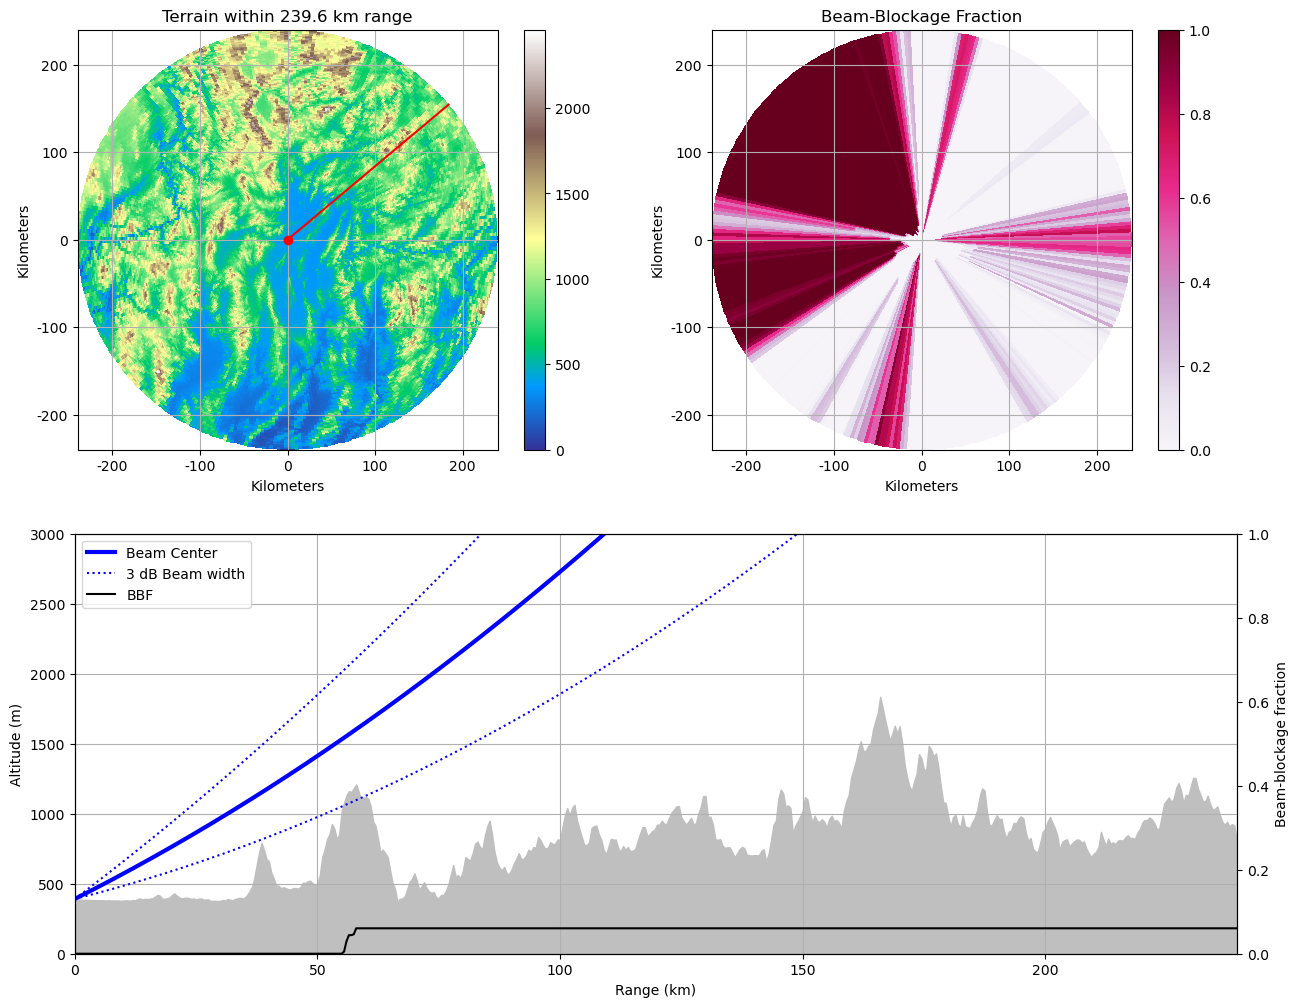

In [24]:
fig = pl.figure(figsize=(15, 12))

# create subplots
ax1 = pl.subplot2grid((2, 2), (0, 0))
ax2 = pl.subplot2grid((2, 2), (0, 1))
ax3 = pl.subplot2grid((2, 2), (1, 0), colspan=2, rowspan=1)

# azimuth angle
#angle = 225

# Plot terrain (on ax1)
ax1, dem = wrl.vis.plot_ppi(
    polarvalues, ax=ax1, r=r, az=coord[:, 0, 1], cmap=mpl.cm.terrain, vmin=0.0
)
ax1.plot(
    [0, np.sin(np.radians(angle)) * 240000], [0, np.cos(np.radians(angle)) * 240000], "r-"
)
ax1.plot(sitecoords[0], sitecoords[1], "ro")
annotate_map(ax1, dem, "Terrain within {0} km range".format(np.max(r / 1000.0) + 0.1))

# Plot CBB (on ax2)
ax2, cbb = wrl.vis.plot_ppi(
    CBB, ax=ax2, r=r, az=coord[:, 0, 1], cmap=mpl.cm.PuRd, vmin=0, vmax=1
)
annotate_map(ax2, cbb, "Beam-Blockage Fraction")

# Plot single ray terrain profile on ax3
(bc,) = ax3.plot(r / 1000.0, alt[angle, :], "-b", linewidth=3, label="Beam Center")
(b3db,) = ax3.plot(
    r / 1000.0,
    (alt[angle, :] + beamradius),
    ":b",
    linewidth=1.5,
    label="3 dB Beam width",
)
ax3.plot(r / 1000.0, (alt[angle, :] - beamradius), ":b")
ax3.fill_between(r / 1000.0, 0.0, polarvalues[angle, :], color="0.75")
ax3.set_xlim(0.0, np.max(r / 1000.0) + 0.1)
ax3.set_ylim(0.0, 3000)
ax3.set_xlabel("Range (km)")
ax3.set_ylabel("Altitude (m)")
ax3.grid()

axb = ax3.twinx()
(bbf,) = axb.plot(r / 1000.0, CBB[angle, :], "-k", label="BBF")
axb.set_ylabel("Beam-blockage fraction")
axb.set_ylim(0.0, 1.0)
axb.set_xlim(0.0, np.max(r / 1000.0) + 0.1)


legend = ax3.legend(
    (bc, b3db, bbf),
    ("Beam Center", "3 dB Beam width", "BBF"),
    loc="upper left",
    fontsize=10,
)

#fig.savefig('C:/Users/Admin/jupyter_wradlib_PBB/1output/'+outputname,dpi=300)  #สามารถบันทึกเป็นภาพได้
#pl.close(fig)

# แสดงผลการวิเคราะห์การเคลื่่อนที่ของลำบีมกับความโค้งของผิวโลก


In [25]:
def height_formatter(x, pos):
    x = (x - 6370000) / 1000
    fmt_str = "{:g}".format(x)
    return fmt_str


def range_formatter(x, pos):
    x = x / 1000.0
    fmt_str = "{:g}".format(x)
    return fmt_str

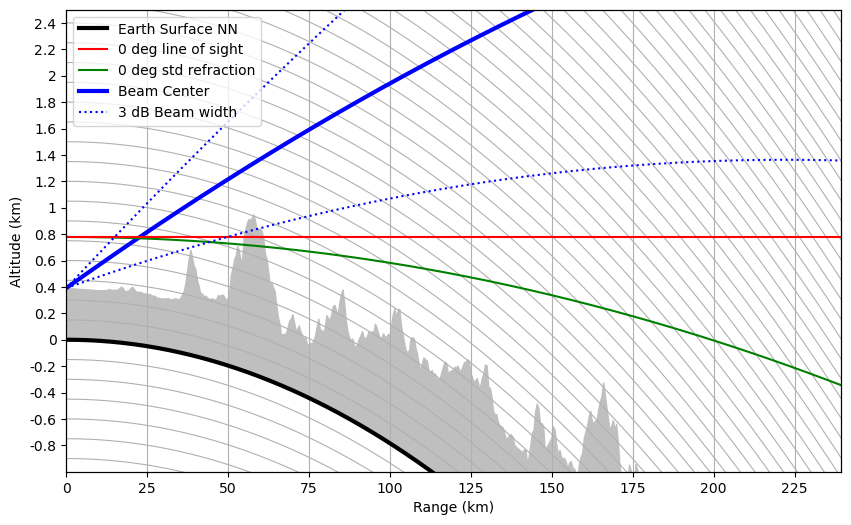

In [26]:
fig = pl.figure(figsize=(10, 6))

cgax, caax, paax = wrl.vis.create_cg(fig=fig, rot=0, scale=1)

# azimuth angle
#angle = 225

# fix grid_helper
er = 6370000
gh = cgax.get_grid_helper()
gh.grid_finder.grid_locator2._nbins = 80
gh.grid_finder.grid_locator2._steps = [1, 2, 4, 5, 10]

# calculate beam_height and arc_distance for ke=1
# means line of sight
bhe = wrl.georef.bin_altitude(r, 0, sitecoords[2], re=er, ke=1.0)
ade = wrl.georef.bin_distance(r, 0, sitecoords[2], re=er, ke=1.0)
nn0 = np.zeros_like(r)
# for nice plotting we assume earth_radius = 6370000 m
ecp = nn0 + er
# theta (arc_distance sector angle)
thetap = -np.degrees(ade / er) + 90.0

# zero degree elevation with standard refraction
bh0 = wrl.georef.bin_altitude(r, 0, sitecoords[2], re=er)

# plot (ecp is earth surface normal null)
(bes,) = paax.plot(thetap, ecp, "-k", linewidth=3, label="Earth Surface NN")
(bc,) = paax.plot(thetap, ecp + alt[angle, :], "-b", linewidth=3, label="Beam Center")
(bc0r,) = paax.plot(thetap, ecp + bh0 + alt[angle, 0], "-g", label="0 deg Refraction")
(bc0n,) = paax.plot(
    thetap, ecp + bhe + alt[angle, 0], "-r", label="0 deg line of sight"
)
(b3db,) = paax.plot(
    thetap, ecp + alt[angle, :] + beamradius, ":b", label="+3 dB Beam width"
)
paax.plot(thetap, ecp + alt[angle, :] - beamradius, ":b", label="-3 dB Beam width")

# orography
paax.fill_between(thetap, ecp, ecp + polarvalues[angle, :], color="0.75")

# shape axes
cgax.set_xlim(0, np.max(ade))
cgax.set_ylim([ecp.min() - 1000, ecp.max() + 2500])
caax.grid(True, axis="x")
cgax.grid(True, axis="y")
cgax.axis["top"].toggle(all=False)
caax.yaxis.set_major_locator(
    mpl.ticker.MaxNLocator(steps=[1, 2, 4, 5, 10], nbins=20, prune="both")
)
caax.xaxis.set_major_locator(mpl.ticker.MaxNLocator())
caax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(height_formatter))
caax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(range_formatter))

caax.set_xlabel("Range (km)")
caax.set_ylabel("Altitude (km)")

legend = paax.legend(
    (bes, bc0n, bc0r, bc, b3db),
    (
        "Earth Surface NN",
        "0 deg line of sight",
        "0 deg std refraction",
        "Beam Center",
        "3 dB Beam width",
    ),
    loc="upper left",
    fontsize=10,
)

* สังเกตุว่า ลำบีมจะสูงขึ้นเรื่อย ๆ ในขณะที่ระยะทางของการเคลื่อนที่ของลำบีมเพิ่มขึ้น

# Export CBB to Geotif เพื่อใช้ใน QGIS

# ประมาณค่าจากpolcoords ไปเป็น grid แบบ lat-lon
https://docs.wradlib.org/en/stable/notebooks/interpolation/wradlib_ipol_example.html

In [27]:
import wradlib.ipol as ipol
from wradlib.vis import plot_ppi

In [28]:
src = polcoords
vals = CBB

In [29]:
src = np.reshape(src,[360*480,2])
vals = np.reshape(vals,[360*480])

In [30]:
xtrg = np.linspace(src[:, 0].min(), src[:, 0].max(), 400)
ytrg = np.linspace(src[:, 1].min(), src[:, 1].max(), 400)
trg = np.meshgrid(xtrg, ytrg)
trg = np.vstack((trg[0].ravel(), trg[1].ravel())).T

In [31]:
ip_lin = ipol.Linear(src, trg)
result_lin = ip_lin(vals.ravel(), fill_value=np.nan)

In [37]:
ip_near = ipol.Nearest(src, trg)
maxdist = trg[1, 0] - trg[0, 0]
result_near = ip_near(vals.ravel(), maxdist=maxdist*2) # *2 คือ ต้องการขยาย effective radius ของการค้นหาจุดเพื่อมาประมาณค่า

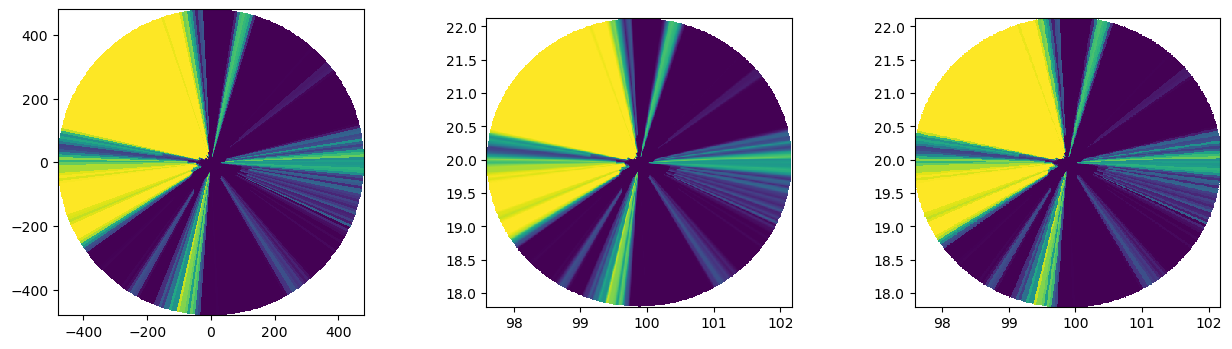

In [38]:
fig = pl.figure(figsize=(15, 6))
fig.subplots_adjust(wspace=0.4)
ax = fig.add_subplot(131, aspect="equal")
plot_ppi(CBB, ax=ax)
ax = fig.add_subplot(132, aspect="equal")
pl.pcolormesh(xtrg, ytrg, result_lin.reshape((len(xtrg), len(ytrg))))
ax = fig.add_subplot(133, aspect="equal")
pl.pcolormesh(xtrg, ytrg, result_near.reshape((len(xtrg), len(ytrg))))

In [34]:
CBB_grid=np.reshape(result_near, (400,400))

In [35]:
trg_grd=np.reshape(trg,(400,400,2))

In [36]:
CBB_rt=wrl.georef.raster.create_raster_dataset(CBB_grid,trg_grd)
wrl.io.write_raster_dataset("CBB_cri_geotif.tif", CBB_rt, "GTiff")

## การนำไปใช้อื่น ๆ เพื่อส่งออกข้อมูลเรดาร์ไปใน QGIS

* สามารถนำข้อมูล polar PPI ของค่าตัวแปรเรดาร์ มาทำการสร้างกริดคาร์ทีเซียน และส่งออกไปในโปรแกรม GIS เป็น Geotif หรือ ใช้กับ Xarray ได้เลย

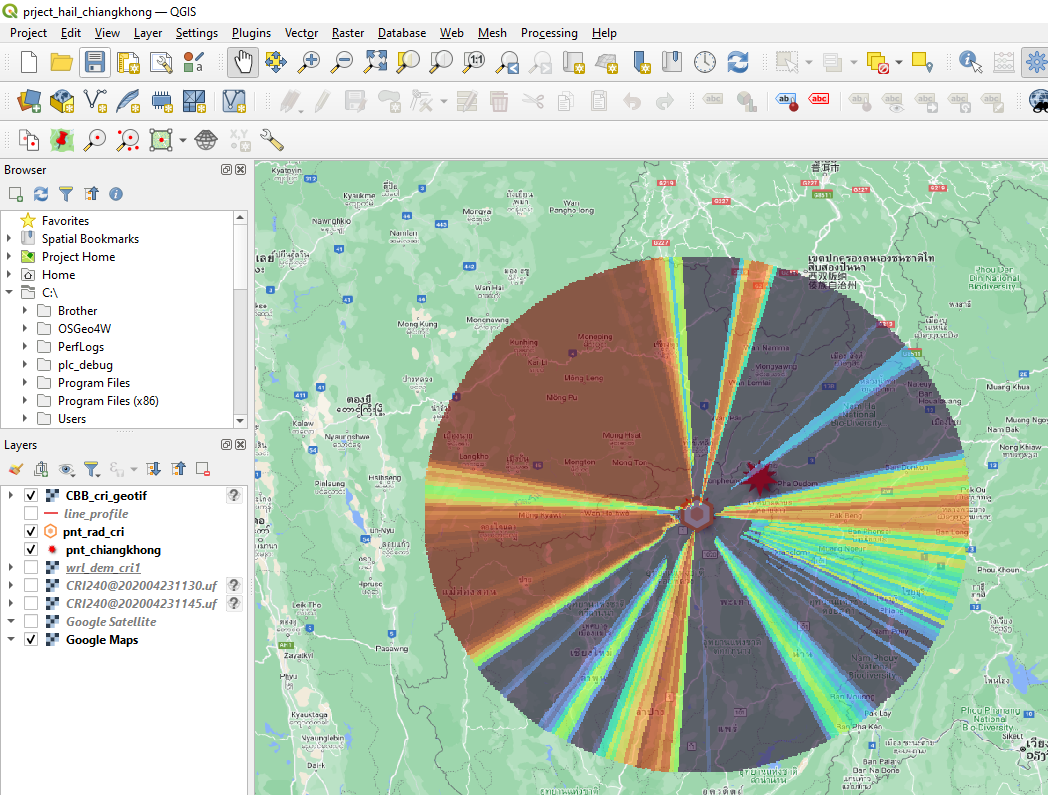 แหล่งที่มา D:\1Yang\0Research\0_2565_hail\03GIS\0CRI_radar_wct\ prject_hail_chiangkhong
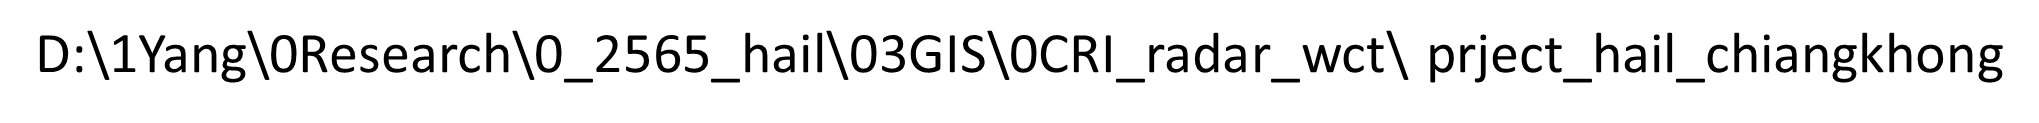